In [117]:
%load_ext autoreload
%autoreload 2
import os
import keras

import numpy as np

from distributions import ZeroInflatedDist, QuantizedNormal
from plotting_funcs import sample_and_plot, plot_dist, plot_hexagon_grid

import tensorflow as tf
import tensorflow_probability as tfp

from functools import partial

seed = 360
seedstep = 0


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


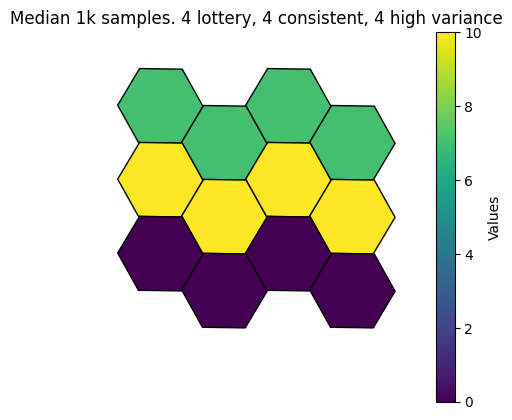

In [118]:
consistent_4 = [QuantizedNormal(7, 0.1) for _ in range(4)]

highvar_4 = [ZeroInflatedDist(QuantizedNormal(10, 0.1), 1-0.7) for _ in range(4)]

powerball_4 = [ZeroInflatedDist(QuantizedNormal(100, 0.1), 0.9) for _ in range(4)]
dist_S = consistent_4 + highvar_4 +powerball_4
S=12
sample_and_plot(dist_S, size=1000, median=True, title='Median 1k samples. 4 lottery, 4 consistent, 4 high variance')

In [119]:
def make_data(dist_S, H=50, T=500, seed=360):
    """Generate data from a list of distributions.
    
    Args:
        dist_S: list of distributions
        H: number of historical observations to be used as features
        T: number of timepoints
        seed: random seed
    Returns
        X_THS: numpy array of shape (T, H, S)
        y_TS: numpy array of shape (T, S)
    """

    # In order to have T timepoints each with H historical observations, we need T+H samples 
    data_HT_S = np.zeros((H+T, S))
    for s, dist in enumerate(dist_S):
        random_state = np.random.RandomState(10000 * seed + s)
        data_HT_S[:, s] = dist.rvs(size=H+T, random_state=random_state)

    X_THS = np.array([data_HT_S[t:H+t,:] for t in range(T)], dtype=np.float32)
    y_TS = np.array([data_HT_S[H+t, :] for t in range(T)], dtype=np.float32)

    return X_THS, y_TS

H = 50
T= 500

X_THS, y_TS = make_data(dist_S, H=H, T=T, seed=360)

# check that each final history is equal to the previous observation
for t in range(H, T):
    assert(np.all(X_THS[t, H-1, :] == y_TS[t-1, :]))

# check random point in history
for t in range(H, T):
    h = np.random.randint(0, H)
    assert(np.all(X_THS[t, h, :] == y_TS[t-(H-h), :]))

In [120]:
keras.utils.set_random_seed(seed+1000*seedstep)
seedstep += 1
# Build our GLM. Use 1D convolution over the history dimension to make our linear model
model = keras.Sequential(
    [
        keras.layers.Input(shape=(H, S)),
        # convolution to turn H,S into 1,S
        # Filters = size oute convolutiput space
        # kernel_size = size of thon window
        # dataformat = channels_first means that the input shape is (batch_size, features, time)
        keras.layers.Conv1D(filters=1, kernel_size=1, activation='softplus', data_format='channels_first'),
        keras.layers.Flatten(),
    ]
)

In [121]:
def poisson_nll(y_true, y_pred):
    """Poisson negative log likelihood loss function.
    
    Args:
        y_true: true values
        y_pred: predicted values
    Returns:
        negative log likelihood
    """
    return y_pred - y_true * tf.math.log(y_pred + 1e-10)

In [122]:
from perturbations.perturbations import perturbed
def top_k_idx(input_BD, **kwargs):
    _, idx_BD = tf.math.top_k(input_BD, **kwargs)
    input_depth = input_BD.shape[-1]
    one_hot_idx_BKD = tf.one_hot(idx_BD, input_depth)
    # Sum over k dimension so we dont have to worry about sorting
    k_hot_idx_BD = tf.reduce_sum(one_hot_idx_BKD, axis=-2)

    return k_hot_idx_BD

K=3
top_K_idx_func = partial(top_k_idx, k=K)

perturbed_top_K = perturbed(top_K_idx_func,
                                num_samples=1000,
                                sigma=1,
                                noise='normal',
                                batched=True)

def negative_bpr_K_uncurried(y_true, y_pred, K=3, perturbed_top_K_func=None):
    
    top_K_ids = perturbed_top_K_func(y_pred)
    true_top_K_val, true_top_K_idx = tf.math.top_k(y_true, k=K)
    denominator = tf.reduce_sum(true_top_K_val, axis=-1)
    numerator = tf.reduce_sum(top_K_ids * y_true, axis=-1)
    loss_val = tf.reduce_mean(-numerator/denominator)

    return loss_val

negative_bpr_K = partial(negative_bpr_K_uncurried,K=K, perturbed_top_K_func=perturbed_top_K)

In [123]:
X_train = X_THS[:300, :, :]
y_train = y_TS[:300, :] 
X_val = X_THS[300:400, :, :]
y_val = y_TS[300:400, :]
X_test = X_THS[400:, :, :]
y_test = y_TS[400:, :]

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024, seed=seed+seedstep*1000).batch(32)
seedstep += 1

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(32)

# calculate val bpr and nll
val_preds = model.predict(X_val)
val_nll = poisson_nll(y_val, val_preds).numpy()
val_bpr = negative_bpr_K(y_val, val_preds).numpy()

print('Val NLL: ', np.mean(val_nll))
print('Val BPR: ', val_bpr)

4/4 [==============================] - 0s 1ms/step


Val NLL:  105.180244
Val BPR:  -0.35415798


In [124]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)

### Optimization problem:
Minimize
$$-\log p(y_s,t| \boldsymbol{x}_{s,t}) =  \hat{y_{s,t}}-y_{s,t} \log {\hat{y_{s,t}}} $$
Subject to:
$$ BPR_K()

In [125]:
penalty = 10.0
bpr_threshold = 0.5

def uncurried_penalized_bpr(y_true, y_pred, penalty=1.0, 
                            bpr_threshold=0.40, negative_bpr_K_func=None):
    
    negative_bpr_K_val = negative_bpr_K_func(y_true, y_pred)
    # threshold is violated when threshold is above bpr
    violate_threshold_flag = tf.cast(tf.greater(bpr_threshold,
                                                -negative_bpr_K_val),
                                     tf.float32)
    
    loss = poisson_nll(y_true, y_pred) + penalty * violate_threshold_flag *(bpr_threshold + negative_bpr_K_val)

    return loss

penalized_bpr_loss = partial(uncurried_penalized_bpr, penalty=penalty, 
                             bpr_threshold=bpr_threshold, 
                             negative_bpr_K_func=negative_bpr_K)
    

In [126]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss=penalized_bpr_loss)

In [127]:
# fit model, plot training and validation loss
history = model.fit(train_dataset, epochs=100, validation_data=val_dataset)


Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got partial
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got partial
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


10/10 [==============================] - 1s 32ms/step - loss: 40.7565 - val_loss: 16.1945
Epoch 2/100
10/10 [==============================] - 0s 20ms/step - loss: 10.4064 - val_loss: 15.0261
Epoch 3/100
10/10 [==============================] - 0s 19ms/step - loss: 11.2540 - val_loss: 13.4109
Epoch 4/100
10/10 [==============================] - 0s 22ms/step - loss: 7.8303 - val_loss: 10.6208
Epoch 5/100
10/10 [==============================] - 0s 30ms/step - loss: 3.6744 - val_loss: 10.6056
Epoch 6/100
10/10 [==============================] - 0s 20ms/step - loss: 1.2809 - val_loss: 10.3012
Epoch 7/100
10/10 [==============================] - 0s 20ms/step - loss: -0.4248 - val_loss: 9.2570
Epoch 8/100
10/10 [==============================] - 0s 20ms/step - loss: -1.1776 - val_loss: 9.4843
Epoch 9/100
10/10 [==============================] - 0s 20ms/step - loss: -1.8445 - val_loss: 9.5381
Epoch 10/100
10/10 [==============================] - 0s 20ms/step - loss: -2.5459 - val_loss: 8.112

Text(0.5, 1.0, 'Training and validation loss. Penalty: 10.0, Threshold: 0.5')

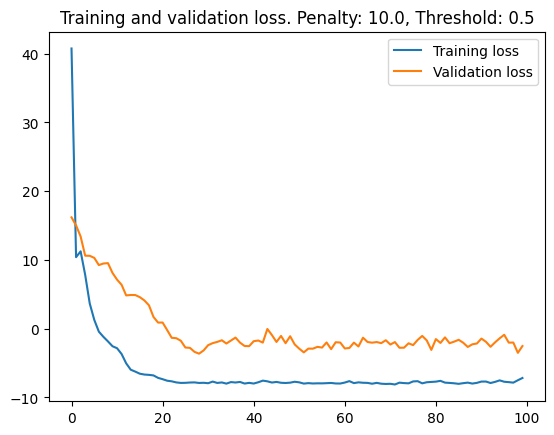

In [128]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
# Title with threshold and penalty
plt.title('Training and validation loss. Penalty: {}, Threshold: {}'.format(penalty, bpr_threshold))

In [129]:
# calculate val bpr and nll
val_preds = model.predict(X_val)
val_nll = poisson_nll(y_val, val_preds).numpy()
val_bpr = negative_bpr_K(y_val, val_preds).numpy()

print('Val NLL: ', np.mean(val_nll))
print('Val BPR: ', val_bpr)

4/4 [==============================] - 0s 1ms/step
Val NLL:  -4.01339
Val BPR:  -0.35047323
